In [4]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [5]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

## LOAD DATASET

In [6]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [7]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
len(dataset)
#because every batch is of 32

68

## VISUALIZATION

In [9]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy()) #because each is in tensor

(32, 256, 256, 3)
[2 1 0 1 1 2 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 2 1 0 0 1 0 2 0 0 2]


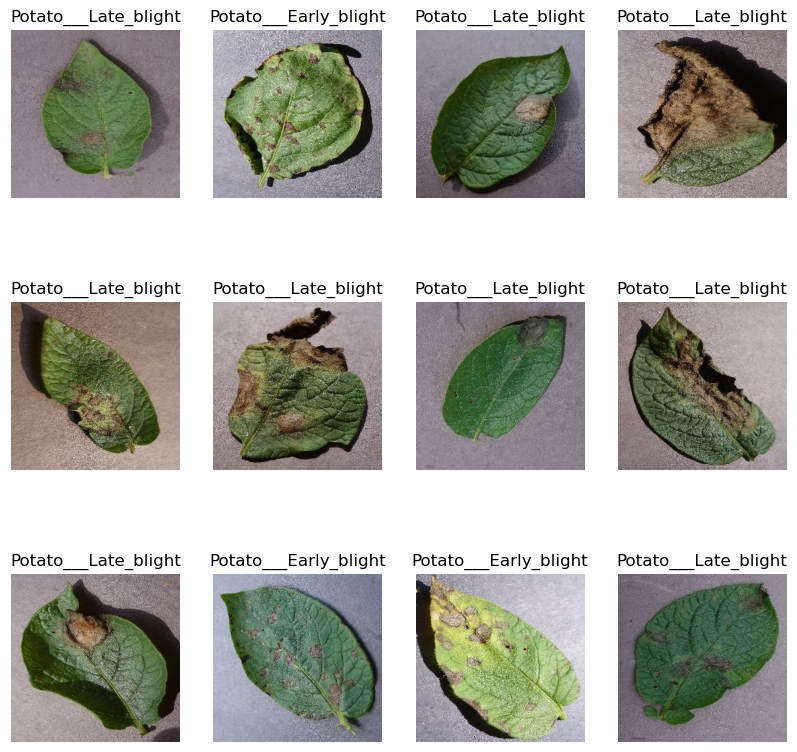

In [10]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8")) #because it is float
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

## TRAIN-TEST SPLIT
###### 80%--Training.......10%--Validation.......10%--Test

### Common Approach

In [11]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [12]:
train_ds=dataset.take(54)
len(train_ds)

54

In [13]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [14]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [15]:
val_size=dataset.take(6)
len(val_size)

6

In [16]:
test_ds=test_ds.skip(6)
len(test_ds)

8

### By Function

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [18]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

54

In [20]:
len(val_ds)

6

In [21]:
len(test_ds)

8

In [22]:
#cache(read image from disk & for next iteration when you need same image it keep image in memory (improves performance)) 

In [23]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Pre-Processing

##### Resizing and Normalization

In [24]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

##### Data Augmentation

In [25]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

### MODEL BUILDING

In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

C:\Users\Hp\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [67]:
Details=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.4988 - loss: 0.8864 - val_accuracy: 0.5938 - val_loss: 0.7632
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.7193 - loss: 0.6321 - val_accuracy: 0.8177 - val_loss: 0.4309
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.8403 - loss: 0.3886 - val_accuracy: 0.8177 - val_loss: 0.3982
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - accuracy: 0.8854 - loss: 0.2900 - val_accuracy: 0.9219 - val_loss: 0.2688
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.8900 - loss: 0.2707 - val_accuracy: 0.9219 - val_loss: 0.2445
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.9190 - loss: 0.2032 - val_accuracy: 0.8698 - val_loss: 0.3417
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - accuracy: 0.9265 - loss: 0.1856 - val_accuracy: 0.9323 - val_loss: 0.2346
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.9387 - loss: 0.1404 - val_accuracy: 0.9323 - v

In [69]:
scores=model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 558ms/step - accuracy: 0.9961 - loss: 0.0138


In [70]:
scores

[0.013808194547891617, 0.99609375]

In [71]:
Details

In [73]:
Details.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [75]:
Details.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [77]:
len(Details.history['accuracy'])

50

In [79]:
acc = Details.history['accuracy']
val_acc = Details.history['val_accuracy']

loss = Details.history['loss']
val_loss = Details.history['val_loss']

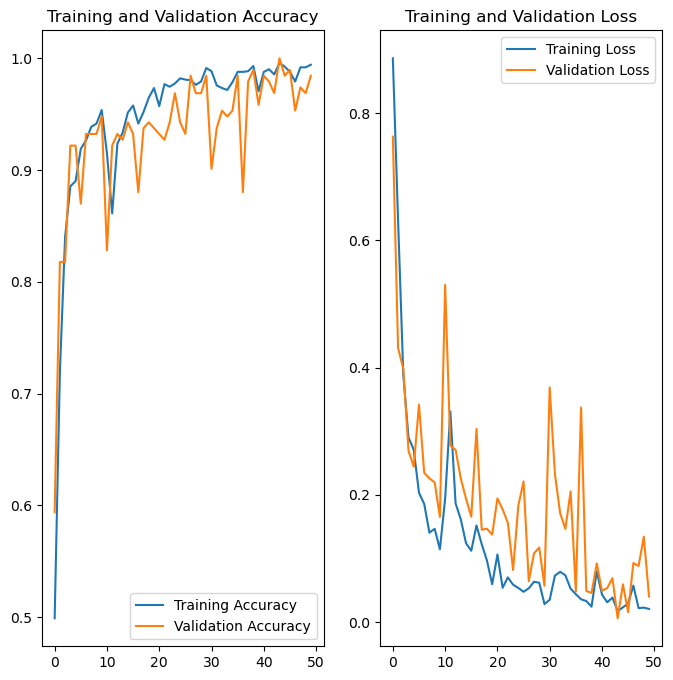

In [80]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
predicted label: Potato___Early_blight


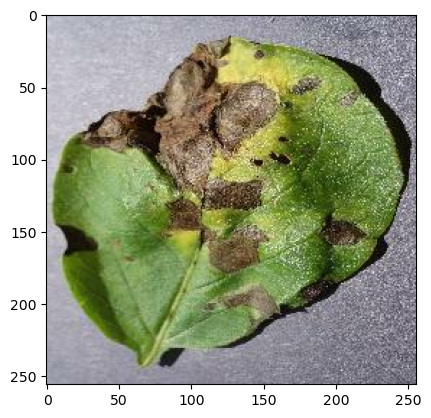

In [82]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[3].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [84]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [85]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


### SAVE MODEL

In [94]:
import os

models_dir = "models"   # use relative path inside plant_Disease
os.makedirs(models_dir, exist_ok=True)

# find version number
model_version = max([int(i.split("_")[-1].split(".")[0]) 
                     for i in os.listdir(models_dir) if i.startswith("model_")] + [0]) + 1

# Save in .keras format
model.save(f"{models_dir}/model_{model_version}.keras")

In [95]:
# Optionally also save in .h5 format
model.save(f"{models_dir}/model_{model_version}.h5")

In [28]:
import os
import pickle

models_dir = "models"  # use relative path inside plant_Disease
os.makedirs(models_dir, exist_ok=True)

# find version number
model_version = max([int(i.split("_")[-1].split(".")[0]) for i in os.listdir(models_dir) if i.startswith("model_")] + [0]) + 1

# Save in .pkl format
with open(f"{models_dir}/model_{model_version}.pkl", 'wb') as f:
    pickle.dump(model, f)